In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
app_train = pd.read_csv("app_train_new.csv").reset_index(drop = True)
app_test = pd.read_csv("app_test_new.csv").reset_index(drop = True)
app_train = app_train.drop("Unnamed: 0", axis=1)
app_test = app_test.drop("Unnamed: 0", axis=1)

In [12]:
app_train["TARGET"].value_counts()

False    282686
True      24825
Name: TARGET, dtype: int64

NAME_INCOME_TYPE_Pensioner and ORGANIZATION_TYPE_XNA: 0.9996475770944251
NAME_INCOME_TYPE_Pensioner和ORGANIZATION_TYPE_XNA高度相关

OBS_30_CNT_SOCIAL_CIRCLE and OBS_60_CNT_SOCIAL_CIRCLE: 0.9984895425113564
OBS_30_CNT_SOCIAL_CIRCLE和OBS_60_CNT_SOCIAL_CIRCLE高度相关

In [9]:
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.ix[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.ix[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    display(df[df['TARGET'] == 0][var_name])
    sns.kdeplot(df.ix[df['TARGET'] == 0, var_name].dropna(), label = 'TARGET == 0')
    sns.kdeplot(df.ix[df['TARGET'] == 1, var_name].dropna(), label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

count    306490.000000
mean          0.016953
std           0.133079
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: OBS_30_60_rate, dtype: float64

c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]
c:

The correlation between OBS_30_60_rate and the TARGET is 0.0034
Median value for loan that was not repaid = 0.0000
Median value for loan that was repaid =     0.0000


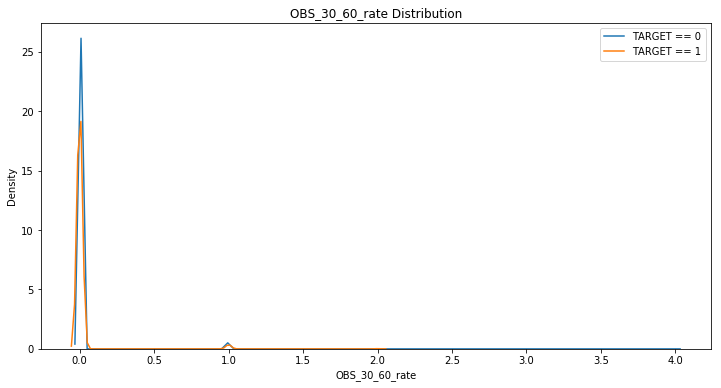

In [25]:
app_train["OBS_30_60_rate"] = (app_train["OBS_30_CNT_SOCIAL_CIRCLE"]-app_train["OBS_60_CNT_SOCIAL_CIRCLE"])
# app_train["OBS_30_60_rate"] = app_train["OBS_30_60_rate"].replace(np.inf, np.nan)
display(app_train["OBS_30_60_rate"].describe())
kde_target("OBS_30_60_rate", app_train)
app_train = app_train.drop(["OBS_30_60_rate"], axis=1)

In [11]:
app_train[app_train["ORGANIZATION_TYPE_XNA"]!=app_train["NAME_INCOME_TYPE_Pensioner"]]["TARGET"].value_counts()

False    24
True      8
Name: TARGET, dtype: int64

In [15]:
app_train[(app_train["ORGANIZATION_TYPE_XNA"]==1) & (app_train["NAME_INCOME_TYPE_Pensioner"]==0)]["TARGET"].value_counts()

False    14
True      8
Name: TARGET, dtype: int64

In [16]:
app_train[app_train["ORGANIZATION_TYPE_XNA"]==1]["TARGET"].value_counts()

False    52384
True      2990
Name: TARGET, dtype: int64

似乎不属于任何机构又不领退休金的人很容易违约

In [13]:
app_train[app_train["ORGANIZATION_TYPE_XNA"]!=app_train["NAME_INCOME_TYPE_Pensioner"]][["ORGANIZATION_TYPE_XNA", "NAME_INCOME_TYPE_Pensioner"]]

,ORGANIZATION_TYPE_XNA,NAME_INCOME_TYPE_Pensioner
1156,1,0
3937,1,0
18196,0,1
23834,1,0
33165,0,1
35352,1,0
37512,1,0
41723,1,0
77179,1,0
78336,1,0


In [30]:
def load_extra_features(app_train, app_test, *tables):
    for df in [app_train, app_test]:
        df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
        df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
        df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
        df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
        df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
        df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
        df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
        df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
        df['WORKING_LIFE_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
        df['INCOME_PER_FAM'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
        df['CHILDREN_RATIO'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']
        
        df["OBS_30_60_diff"] = (df["OBS_30_CNT_SOCIAL_CIRCLE"]-df["OBS_60_CNT_SOCIAL_CIRCLE"])
        
    for table in tables:
        app_train = app_train.merge(right=table.reset_index(), how='left', on='SK_ID_CURR')
        app_test = app_test.merge(right=table.reset_index(), how='left', on='SK_ID_CURR')
    return app_train, app_test


In [26]:
bureau = pd.read_csv("bureau_new.csv").reset_index(drop = True)
bureau = bureau.drop("Unnamed: 0", axis=1)
bureau[["DAYS_CREDIT", "DAYS_CREDIT_ENDDATE"]]

,DAYS_CREDIT,DAYS_CREDIT_ENDDATE
0,-497,-153.0
1,-208,1075.0
2,-203,528.0
3,-203,NaN
4,-629,1197.0
5,-273,27460.0
6,-43,79.0
7,-1896,-1684.0
8,-1146,-811.0
9,-1146,-484.0


In [ ]:
def load_bureau(bureau, buro_balance):
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    bb_cat = [col for col in buro_balance.columns if len(buro_balance[col].unique()) == 2]
    bb_aggregations.update({col: ["mean"] for col in bb_cat})
    buro_balance_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    buro_balance_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in buro_balance_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()
    
    bureau["DAYS_CREDIT_ITERVAL"] = bureau["DAYS_CREDIT"] - bureau["DAYS_CREDIT_ENDDATE"]
    bureau["CREDIT_SUM_DEBT_RATIO"] = bureau["AMT_CREDIT_SUM_DEBT"] / bureau["AMT_CREDIT_SUM"]
    bureau["CREDIT_SUM_OVERDUE_RATIO"] = bureau["AMT_CREDIT_SUM_OVERDUE"] / bureau["AMT_CREDIT_SUM"]
    bureau["CREDIT_SUM_LIMIT_DEBT_RATIO"] = bureau["AMT_CREDIT_SUM_DEBT"] / bureau["AMT_CREDIT_SUM_LIMIT"]
    bureau["CREDIT_SUM_LIMIT_OVERDUE_RATIO"] = bureau["AMT_CREDIT_SUM_OVERDUE"] / bureau["AMT_CREDIT_SUM_LIMIT"]
    bureau["ANNUITY_DEBT_RATIO"] = bureau["AMT_CREDIT_SUM_DEBT"] / bureau["AMT_ANNUITY"]
    bureau["ANNUITY_OVERDUE_RATIO"] = bureau["AMT_CREDIT_SUM_OVERDUE"] / bureau["AMT_ANNUITY"]
    bureau["MAX_OVERDUE_RATIO"] = bureau["AMT_CREDIT_SUM_OVERDUE"] / bureau["AMT_CREDIT_MAX_OVERDUE"]
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
        
        "DAYS_CREDIT_ITERVAL": ['min', 'max', 'mean', 'var'],
        "CREDIT_SUM_DEBT_RATIO": ['min', 'max', 'mean', 'var'],
        "CREDIT_SUM_OVERDUE_RATIO": ['min', 'max', 'mean', 'var'],
        "CREDIT_SUM_LIMIT_DEBT_RATIO": ['min', 'max', 'mean', 'var'],
        "CREDIT_SUM_LIMIT_OVERDUE_RATIO": ['min', 'max', 'mean', 'var'],
        "ANNUITY_DEBT_RATIO": ['min', 'max', 'mean', 'var'],
        "ANNUITY_OVERDUE_RATIO": ['min', 'max', 'mean', 'var'],
        "MAX_OVERDUE_RATIO": ['min', 'max', 'mean', 'var'],
    }
    cat_aggregations = {cat: ['mean'] for cat in bureau_cat}
    cat_aggregations.update({col + "_MEAN": ["mean"] for col in bb_cat})
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    del bureau
    gc.collect()
    return bureau_agg

In [4]:
prev = pd.read_csv("previous_new.csv").reset_index(drop = True)
prev = prev.drop("Unnamed: 0", axis=1)

prev.shape

(1670214, 163)

In [ ]:
def load_prev(prev):
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev["APP_DURATION"] =  prev["DAYS_TERMINATION"] - prev["DAYS_DECISION"]
    prev["APP_PAY_DURATION"] = prev["DAYS_LAST_DUE"] - prev["DAYS_FIRST_DRAWING"]
    prev["INTREST_RATE_RATIO"] = prev["RATE_INTEREST_PRIVILEGED"]/prev["RATE_INTEREST_PRIMARY"]
    prev['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        
        "APP_DURATION": ['max', 'mean', 'sum'],
        "APP_PAY_DURATION": ['max', 'mean', 'sum'],
        "INTREST_RATE_RATIO": ['max', 'mean', 'sum', 'var'],
        'CREDIT_TO_GOODS_RATIO': ['max', 'mean', 'sum', 'var'],
    }
    cat_aggregations = {col: ["mean"] for col in prev.columns if len(prev[col].unique()) == 2}
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    prev_agg = prev_agg.join(prev_agg, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
    return prev_agg

In [5]:
inst = pd.read_csv("installments_new.csv").reset_index(drop = True)
inst = inst.drop("Unnamed: 0", axis=1)

inst.shape

(13605401, 8)

In [16]:
prev[["DAYS_DECISION", 'DAYS_LAST_DUE', "DAYS_FIRST_DRAWING", "DAYS_TERMINATION", "RATE_INTEREST_PRIMARY", "RATE_INTEREST_PRIVILEGED"]][50:100]

,DAYS_DECISION,DAYS_LAST_DUE,DAYS_FIRST_DRAWING,DAYS_TERMINATION,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED
50,-161,NaN,NaN,NaN,NaN,NaN
51,-766,-466.0,365243.0,-464.0,NaN,NaN
52,-774,NaN,NaN,NaN,NaN,NaN
53,-598,-357.0,365243.0,-344.0,NaN,NaN
54,-409,NaN,NaN,NaN,NaN,NaN
55,-557,-197.0,365243.0,-194.0,NaN,NaN
56,-1042,-742.0,365243.0,-738.0,NaN,NaN
57,-209,NaN,NaN,NaN,NaN,NaN
58,-183,-3.0,365243.0,NaN,NaN,NaN
59,-1773,-1472.0,365243.0,-1464.0,NaN,NaN


In [ ]:

def load_install(inst):
    inst["DPD"] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']
    inst["DBD"] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    inst['DPD'] = inst['DPD'].apply(lambda x: x if x > 0 else 0)
    inst['DBD'] = inst['DBD'].apply(lambda x: x if x > 0 else 0)
    inst['PAYMENT_PERC'] = inst['AMT_PAYMENT'] / inst['AMT_INSTALMENT']
    inst['PAYMENT_DIFF'] = inst['AMT_INSTALMENT'] - inst['AMT_PAYMENT']
    
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        "INSTAL_COUNT": ["size"]
    }
    inst_agg = inst.groupby('SK_ID_CURR').agg(aggregations)
    inst_agg["INSTAL_TOTAL_PAYMENT_RATE"] = inst["AMT_PAYMENT_sum"]/inst["AMT_INSTALMENT_sum"]
    inst_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    inst_agg['INSTAL_COUNT'] = inst.groupby('SK_ID_CURR').size()
#     del inst
#     gc.collect()
    return ins_agg

In [ ]:
def load_cash(cash):
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean'],
        "CNT_INSTALMENT": ['max', 'mean', 'sum', 'var'],
        "CNT_INSTALMENT_FUTURE": ['max', 'mean', 'sum', 'var'],
    }
    aggregations.update({col: ["mean"] for col in cash.columns if len(cash[col].unique()) == 2})
    cash_agg = cash.groupby('SK_ID_CURR').agg(aggregations)
    cash_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in cash_agg.columns.tolist()])
    # Count pos cash accounts
    cash_agg['POS_COUNT'] = cash.groupby('SK_ID_CURR').size()
    del cash
    gc.collect()
    return cash_agg

In [ ]:
def load_credit(credit):
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean'],
        "CNT_INSTALMENT": ['max', 'mean', 'sum', 'var'],
        "CNT_INSTALMENT_FUTURE": ['max', 'mean', 'sum', 'var'],
    }
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

3 columns of app_train were label encoded: ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

0 columns of bureau were label encoded: []

0 columns of bureau_balance were label encoded: []

1 columns of previous were label encoded: ['FLAG_LAST_APPL_PER_CONTRACT']

In [34]:
import modelling

# app_train, app_test = load_extra_features(app_train, app_test)

# to_del_cols = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'AMT_GOODS_PRICE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'ORGANIZATION_TYPE_XNA']

# app_train = app_train.drop(to_del_cols, axis=1)
# app_test = app_test.drop(to_del_cols, axis=1)

print(set(app_train.columns) - set(app_test.columns))
cat_feats = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
submission, fi, metrics = modelling.model(app_train, app_test, cat_feats)
print('Baseline metrics')
print(metrics)
submission.to_csv('improved_lgb.csv', index = False)

{'TARGET'}


c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.803513	train's binary_logloss: 0.541968	valid's auc: 0.763755	valid's binary_logloss: 0.557343
Early stopping, best iteration is:
[273]	train's auc: 0.815485	train's binary_logloss: 0.530011	valid's auc: 0.764122	valid's binary_logloss: 0.549975


c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.803459	train's binary_logloss: 0.542144	valid's auc: 0.765519	valid's binary_logloss: 0.558263
[400]	train's auc: 0.833785	train's binary_logloss: 0.511035	valid's auc: 0.766008	valid's binary_logloss: 0.539251
Early stopping, best iteration is:
[341]	train's auc: 0.825799	train's binary_logloss: 0.519441	valid's auc: 0.766027	valid's binary_logloss: 0.544466


c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.803067	train's binary_logloss: 0.542861	valid's auc: 0.769599	valid's binary_logloss: 0.558098
Early stopping, best iteration is:
[235]	train's auc: 0.808808	train's binary_logloss: 0.537122	valid's auc: 0.769778	valid's binary_logloss: 0.554592


c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.803718	train's binary_logloss: 0.542074	valid's auc: 0.763697	valid's binary_logloss: 0.557722
Early stopping, best iteration is:
[270]	train's auc: 0.815691	train's binary_logloss: 0.529872	valid's auc: 0.764326	valid's binary_logloss: 0.550424


c:\users\yyq\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.804392	train's binary_logloss: 0.541222	valid's auc: 0.764149	valid's binary_logloss: 0.558901
[400]	train's auc: 0.835324	train's binary_logloss: 0.509799	valid's auc: 0.764623	valid's binary_logloss: 0.539394
Early stopping, best iteration is:
[342]	train's auc: 0.827432	train's binary_logloss: 0.517874	valid's auc: 0.764857	valid's binary_logloss: 0.544537
----------------------------training finished---------------------------
best iteration: 342
Baseline metrics
      fold     train     valid
0        0  0.815485  0.764122
1        1  0.825799  0.766027
2        2  0.808808  0.769778
3        3  0.815691  0.764326
4        4  0.827432  0.764857
5  overall  0.818643  0.765772


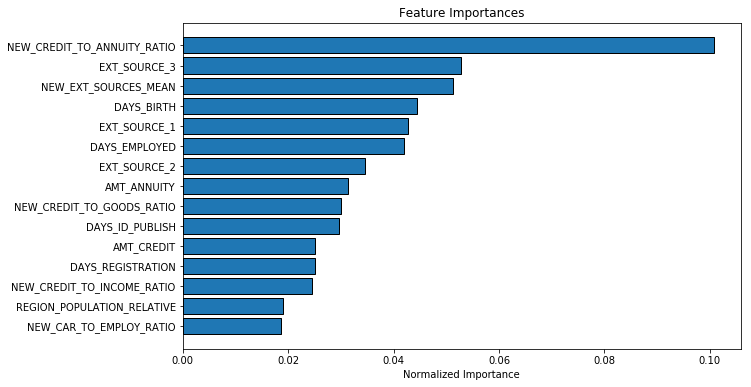

,index,feature,importance,importance_normalized
203,218,ORG_XNA_no_Pensioner,0.0,0.0


In [41]:
import importlib
importlib.reload(modelling)
fi_sorted = modelling.plot_feature_importances(fi)
display(fi_sorted[fi_sorted["feature"]=="ORG_XNA_no_Pensioner"])